In [1]:
from read_roi import read_roi_file, read_roi_zip
import skimage.io as io
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
import random
import os
from datetime import datetime

from sklearn.mixture import GaussianMixture
from sklearn import metrics # Calinski-Harabasz Index评估的聚类分数
# evaluation using sklearn
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.metrics import confusion_matrix

from skimage.filters import gaussian, median, laplace
from skimage.morphology import disk, erosion
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse, resize
from skimage.feature import canny, hog
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.segmentation import active_contour
from skimage.transform import hough_line, hough_line_peaks
from skimage import io

from detection_data import ims_T1, ims_T2, pos
from detection_data import x_trainT1, x_trainT2, y_trainT1, y_trainT2
from detection_data import x_valT1, x_valT2, y_valT1, y_valT2

from utils import label_size, modify_label_size, input_size
from utils import find_rect, gmm, kmeans, rois_dict_to_axis, get_rois, reduce_size_from_indice
from detection_model import Net, num_classes

train data: 
(36358, 36, 36, 1) float32
(36064, 36, 36, 1) float32
(36358,) int64
(36064,) int64

validation data: 
(13916, 36, 36, 1) float32
(13916, 36, 36, 1) float32
(13916,) int64
(13916,) int64


In [2]:
# reload the model
net = Net(num_classes)
net.load_weights(filepath="./detection_model_weights/save_model_weights_36x36.ckpt")

# define a class

In [24]:
class Detection():
    def __init__(self, model, ims, input_size, pos):
        self.model = model
        self.ims = ims.squeeze()
        self.N = len(self.ims)
        self.input_size = input_size
        self.pos = pos
        
    def operate(self, rate):
        print(80 * "=")
        print('OPERATING')
        print(80 * "=")
        start=datetime.now()
        self.rate = rate
        self.indices_pred_ens = []
        self.cluster_model_ens = []
        self.inds_anomal = [] 
        self.center_indices_ens = []
        
        for i, im in enumerate(self.ims):
            # reduce the image size to a rectangle
            precision = 2    
            im_rect, l, r = find_rect(im, orientations=4, pixels_per_cell=(512,precision),
                                    cells_per_block=(2,2))
            im_rect = im_rect[:,l:r]
            
            # input data to the model
            rois_im, indices = self.find_roi(im_rect, self.input_size, strides = (2,2))
            indices = np.array(indices)
            indices[:,1] += l
            indices = indices[:,:2]
            
            # predctions
            results = self.model(rois_im[:,:,:,np.newaxis])
            #preds = np.argmax(results, axis=1)
            
            # get positive indices
            pos_indices, neg_indices = self.predction_from_results(results, indices, self.rate)
            if len(pos_indices) is not 0:
                pos_indices_point = (np.array(pos_indices))[:,:2].reshape(-1,2)       
            
                # chose the best n by using calinski_harabasz_score and silhouette_score
                indices_pred, cluster_model = self.clustering(pos_indices_point)
                self.indices_pred_ens.append(indices_pred)
                self.cluster_model_ens.append(cluster_model)
            else:
                print('Encounter a problem detecting image of indice',i)
                self.inds_anomal.append(i)
                self.indices_pred_ens.append(None)
                self.cluster_model_ens.append(None)
                
            # get center clusters
            center_indices = np.around(self.cluster_model_ens[i].means_).astype(np.int64)
            # 去掉最下面那一个roi
            ind = np.argmax(center_indices,0)[0]
            center_indices = np.delete(center_indices, obj = ind, axis = 0)
            self.center_indices_ens.append(center_indices)

        print('time consuming: ', datetime.now()-start)
        
    def draw_figure(self, inds):
        print(80 * "=")
        print('DRAWING FIGURE')
        print(80 * "=")
        inds = list(inds)
        plt.figure(figsize = (10,10*len(inds)))
        colormap = plt.cm.gist_ncar   
        colors = [colormap(i) for i in np.linspace(0, 1, 4)] 
        for i, ind in enumerate(inds):
            if ind not in self.inds_anomal:
                im = self.ims[ind]
                indices_pred = self.indices_pred_ens[ind]
                cluster_model = self.cluster_model_ens[ind]
                center_indices = np.around(cluster_model.means_).astype(np.int64)
                gt = self.ground_truth(im, self.pos[i], center_indices)
                
                plt.subplot(len(inds),1,i+1)
                plt.imshow(im,cmap='gray')
                plt.axis('off')
                plt.title(ind)
                [self.plot_roi_from_indice(im, self.input_size, center_indices[i], colors[2]) for i in range(len(center_indices)) if gt[i]==1] 
                [self.plot_roi_from_indice(im, self.input_size, center_indices[i], colors[1]) for i in range(len(center_indices)) if gt[i]==0]
            else:
                print('Image of indice', ind ,'took out')
        plt.show()
        
    def evaluation(self):
        print(80 * "=")
        print('EVALUATION')
        print(80 * "=")
        pos = self.pos
        TPs = []
        FPs = []
        for i,im in enumerate(self.ims):
            # 找到ground truth
            gt = self.ground_truth(im, self.pos[i], self.center_indices_ens[i])
            # 考虑到evaluation 的 indice全部都预测为正，因此只需要计算TP和FP
            TPs.append(np.sum(gt))
            FPs.append(gt.shape[0] - np.sum(gt))
        
        # 查准率, 指的是在所有预测正的里面正确的比例
        print('Model evaluation: TP: ', np.array(TPs).sum().astype(np.int), ' | FP: ', np.array(FPs).sum().astype(np.int), 
            ' | precision score: ',np.array(TPs).sum()/(np.array(FPs).sum()+np.array(TPs).sum()))
    
    def read_and_save_rois(self, dir_rois):
        print(80 * "=")
        print('SAVING ROI')
        print(80 * "=")
        if not os.path.exists(dir_rois):
            os.makedirs(dir_rois)
        rois = []
        n = 0
        for i, center_indices in enumerate(self.center_indices_ens):
            for y, x in center_indices:
                n += 1
                x = int(x)
                y = int(y)
                roi = self.ims[i][y:y+self.input_size[0], x:x+self.input_size[1]]
                rois.append(roi)
                io.imsave(os.path.join(dir_rois, str(n)+'.tiff'), roi.astype(np.float32))   # from float64 to float32 saved as tif

        print('Rois figures saved to {} successfully'.format(dir_rois))
        return rois
               
    def read_and_save_rois_axis(self, dir_rois):
        if not os.path.exists(dir_rois):
            os.makedirs(dir_rois)
            
        np.save(os.path.join(dir_rois,'rois_axis_ens.npy'), np.array(self.center_indices_ens))
        print('Rois axis npy file saved to {} successfully'.format(dir_rois))
        return self.center_indices_ens
        
    def get_rois_axis(self):
        return self.center_indices_ens   
    
    def ground_truth(self, im, pos, indices, tol = 5):
        dir_labels = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\positive ROI'
        dir_labels = os.path.join(dir_labels,'T'+str(pos[0])+' SAG')
        dir_labels = os.path.join(dir_labels,str(pos[1])+'_'+str(pos[2]))
        rois_dict = read_roi_zip(dir_labels + '.zip')
        axis_ens = np.array(rois_dict_to_axis(rois_dict))
        #axis_ens = reduce_size_from_indice(axis_ens, modify_label_size)

        gt_true = np.zeros(indices.shape[0],)  # 第一列是gt,第二列是preds
        gt = []
        for (x,y,_,_) in axis_ens:
            x += ceil((label_size[1]-modify_label_size[1])/2)
            y += floor((label_size[0]-modify_label_size[0])/2)
            gt.append([y,x])
        gt = np.array(gt)

        tol += modify_label_size[0] - input_size[0]
        for i,(test_y,test_x) in enumerate(indices):
            for (gt_y,gt_x) in gt:
                if (test_y-gt_y)< tol and (test_x-gt_x)< tol:
                    gt_true[i] = 1
                    continue

        return gt_true

    def plot_roi_from_indice(self, ims, input_size, indice, if_label = False):
        """Plot roi from one indice"""
        h, w = input_size
        x, y = indice[1], indice[0] 
        X = [x,x,x+w,x+w,x]
        Y = [y,y+h,y+h,y,y]
        c = np.array([X,Y]).T
        if if_label == False:
            plt.plot(c[:, 0], c[:, 1], '-b', lw=2)
        else:
            plt.plot(c[:, 0], c[:, 1], '-b', lw=2, color = if_label) 
        
    def from_im_to_indices(self,im, input_size, strides):
        '''
        change from an image to patches indices as the input of CNN network
        input: 
            input_size: input_size[0]*input_size[1] of input of CNN network 
            strides: stride[0]*stride[1] of the moving steps 
        output:
            patches indices of an image of form: (left top width height)
        '''
        indices = []

        h, w = im.shape
        for i in range(0, h-input_size[0]+1, strides[0]):
            for j in range(0, w-input_size[1]+1, strides[1]):
                indices.append([i, j, input_size[0], input_size[1]])
        return indices
    
    def from_indices_to_patches(self, im, indices):
        patches = []
        for (i, j, h, w) in indices:
            patches.append(im[i:i+h, j:j+w])
        return patches
    
    def find_roi(self, im, input_size, strides):
        '''find the rois of an image by using CNN model'''
        indices = self.from_im_to_indices(im, input_size, strides)
        patches = self.from_indices_to_patches(im, indices)
        rois_im = np.array(patches).astype(np.float32)
        return rois_im, indices
            
    def predction_from_results(self, results, indices, rate):
        pos_indices = []
        neg_indices = []
        for ind, (y1,y2) in enumerate(results): 
            if y2 > rate:
                pos_indices.append(indices[ind])
            else:
                neg_indices.append(indices[ind])
        return pos_indices, neg_indices
    
    def clustering(self, pos_indices_point):
        '''chose the best n by using calinski_harabasz_score and silhouette_score'''        
        scores = np.zeros((5,2))
        for k in range(6,11):
            cluster_model = GaussianMixture(n_components = k)
            indices_pred = cluster_model.fit_predict(pos_indices_point)
            #print(pos_indices_point)
            #print(indices_pred)
            scores[k-6,0] = metrics.calinski_harabasz_score(pos_indices_point, indices_pred)
            scores[k-6,1] = metrics.silhouette_score(pos_indices_point, indices_pred)
        scores[:,0] = (scores[:,0] - scores[:,0].mean())/(scores[:,0].std())
        scores[:,1] = (scores[:,1] - scores[:,1].mean())/(scores[:,1].std())
        scores = np.sum(scores, axis=1)
        k_chosen = scores.argmax() + 6
        
        cluster_model = GaussianMixture(n_components = k_chosen)
        indices_pred = cluster_model.fit_predict(pos_indices_point)
        #score = metrics.calinski_harabasz_score(pos_indices_point, indices_pred)
        return indices_pred, cluster_model
    
    def extract_rois_from_image(self, im, input_size, indices):
        rois = []
        for x,y in indices:
            rois.append(im[x:x+input_size[1],y:y+input_size[0]])
        return rois

    def from_normalization_to_origin(self, rois, conf):
        return (np.array(rois) * conf[1] + conf[0]).astype(np.int16)
    
chosen_rate = 1 - 1e-1
detection_machine = Detection(net, ims_T1, input_size, pos)
detection_machine.operate(chosen_rate)
detection_machine.evaluation()

#dir_rois = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\ROI detected'
#rois = detection_machine.read_and_save_rois(dir_rois)

OPERATING
time consuming:  0:09:00.074165
EVALUATION
Model evaluation: TP:  513  | FP:  7  | precision score:  0.9865384615384616
SAVING ROI
Rois saved successfully


DRAWING FIGURE


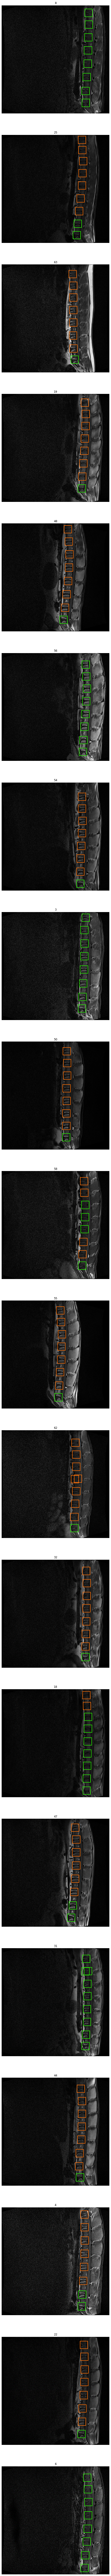

In [6]:
# randomly draw some results
detection_machine.draw_figure(random.sample(list(np.arange(len(ims_T1))),20))

DRAWING FIGURE


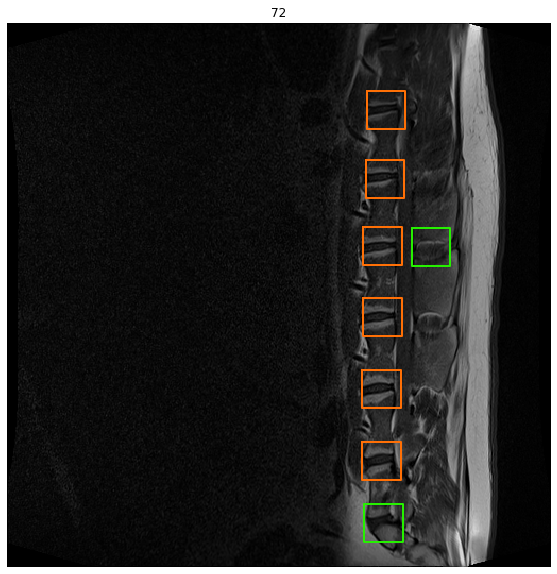

In [7]:
# draw some bad results
detection_machine.draw_figure(np.array([72]))

# trial

In [3]:
def from_im_to_indices(im, input_size, strides):
    '''
    change from an image to patches indices as the input of CNN network
    input: 
        input_size: input_size[0]*input_size[1] of input of CNN network 
        strides: stride[0]*stride[1] of the moving steps 
    output:
        patches indices of an image of form: (left top width height)
    '''
    indices = []
    
    h, w = im.shape
    for i in range(0, h-input_size[0]+1, strides[0]):
        for j in range(0, w-input_size[1]+1, strides[1]):
            indices.append([i, j, input_size[0], input_size[1]])
    return indices

def from_indices_to_patches(im, indices):
    patches = []
    for (i, j, h, w) in indices:
        patches.append(im[i:i+h, j:j+w])
    return patches

def find_roi(im, input_size, strides):
    '''find the rois of an image by using CNN model'''
    indices = from_im_to_indices(im, input_size, strides)
    patches = from_indices_to_patches(im, indices)
    rois_im = np.array(patches).astype(np.float32)
    return rois_im, indices

# 几个复杂情况 n=8, 9, 16, 20, 61, 63, 72, 经过模型的改进后，只有72有一个多的错误框，但是却可以自动排除这个错误框
# n = 48,是T1和T2图片很不对应的情况
n = np.random.randint(ims_T1.shape[0])
n = 58
im_T1 = ims_T1[n]
im_T2 = ims_T2[n] 
#im_T1 = gaussian(im_T1,sigma=1)
#im_T1 = median(im_T1, disk(1))

# reduce the image size to a rectangle
precision = 2  
im_rect, l, r = find_rect(im_T1, orientations=4, pixels_per_cell=(512,precision), cells_per_block=(2,2))
im_rect = im_rect[:,l:r]

strides = (2,2)
rois_im, indices = find_roi(im_rect, input_size, strides)
indices = np.array(indices)
indices[:,1] += l
indices = indices[:,:2]
print(rois_im.shape)
print(indices.shape)

# predctions
results = net(rois_im[:,:,:,np.newaxis])
preds = np.argmax(results, axis=1)

(8126, 36, 36)
(8126, 2)


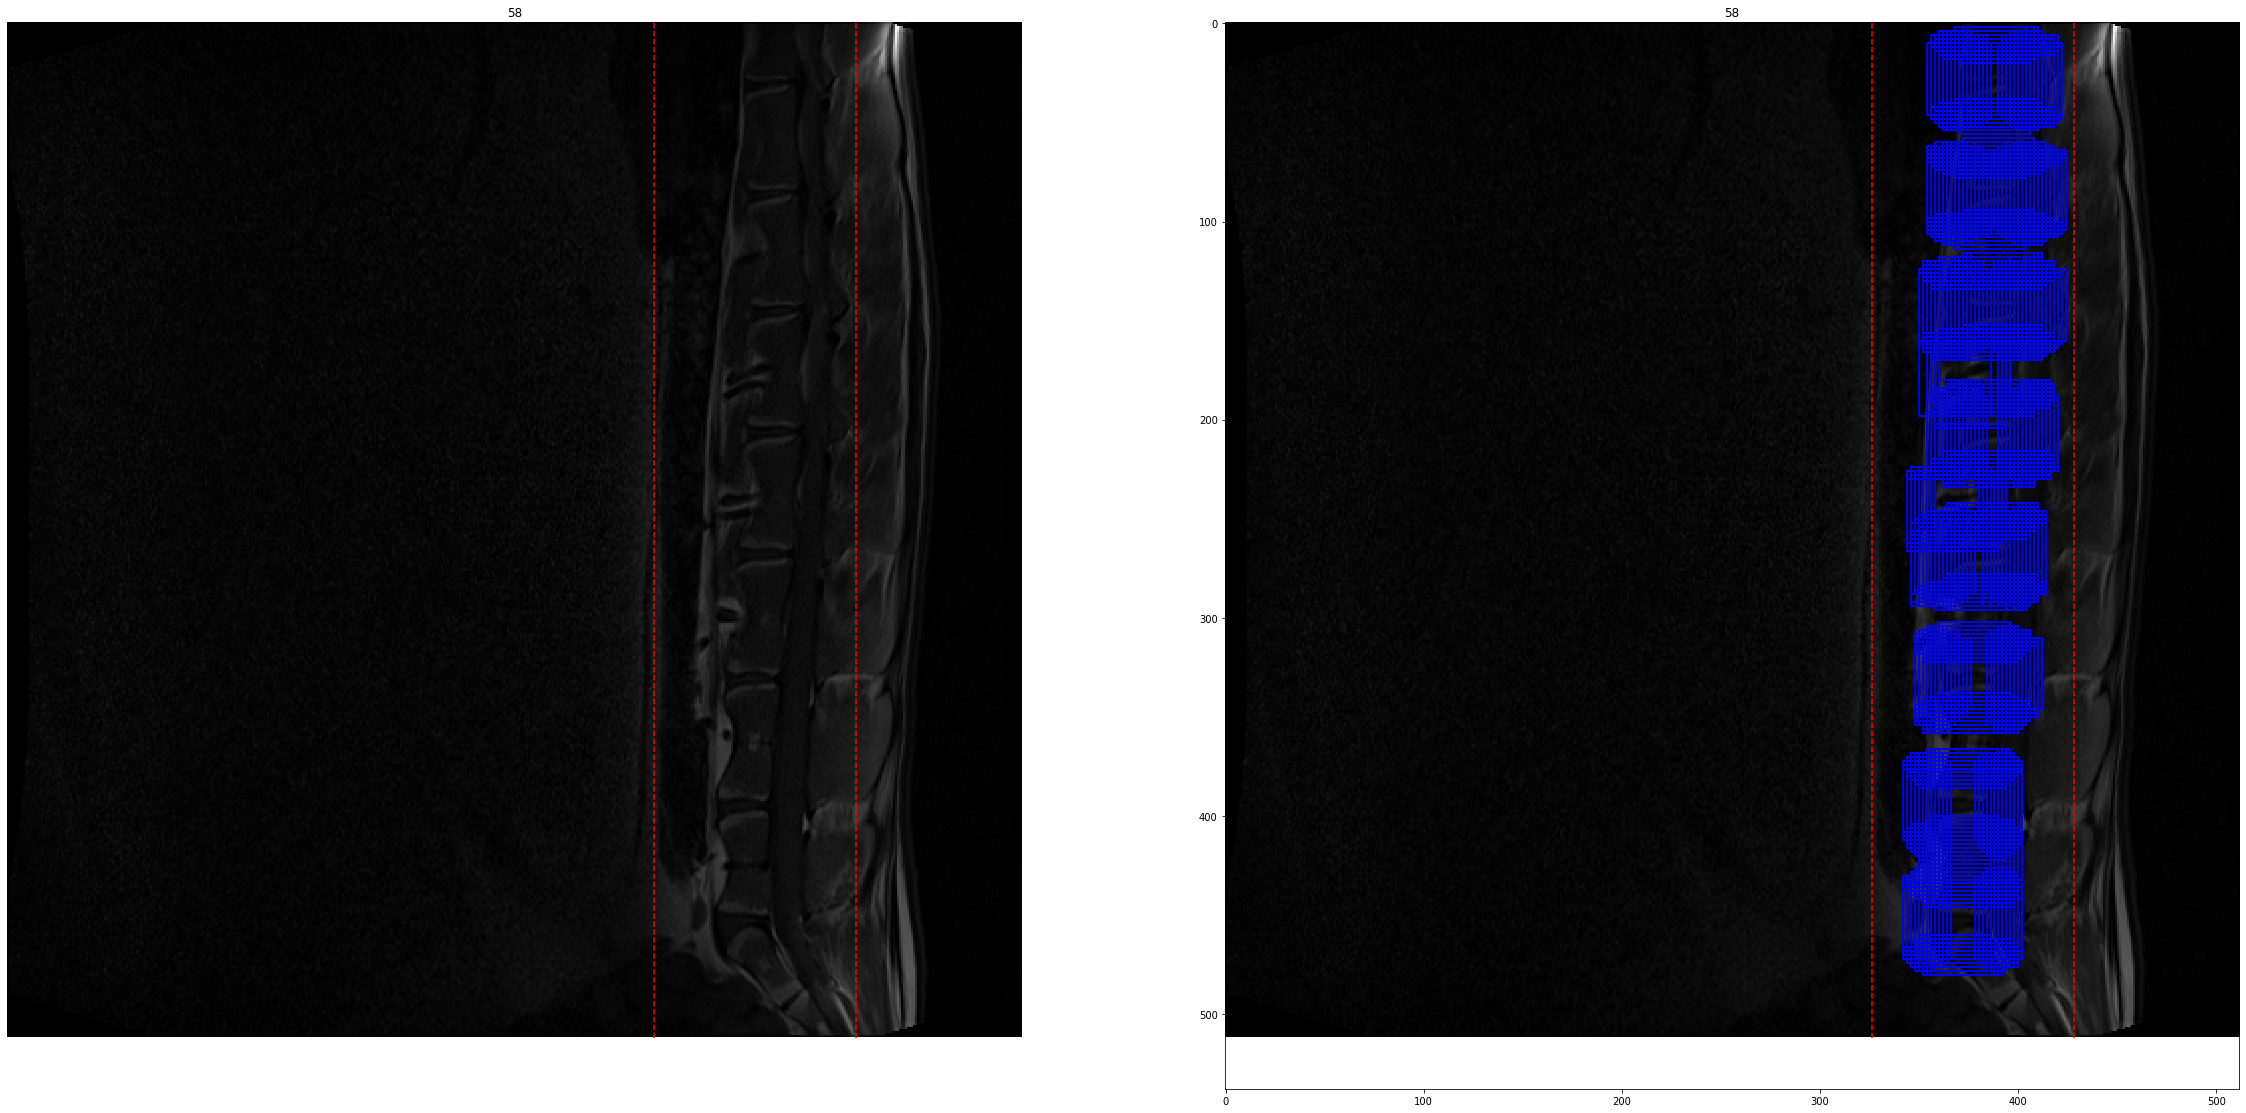

In [4]:
# draw figures
def plot_roi_from_indice(im, input_size, indice, if_label = False):
    """Plot roi from one indice"""
    h, w = input_size
    x, y = indice[1], indice[0] 
    X = [x,x,x+w,x+w,x]
    Y = [y,y+h,y+h,y,y]
    c = np.array([X,Y]).T
    if if_label == False:
        plt.plot(c[:, 0], c[:, 1], '-b', lw=2)
    else:
        plt.plot(c[:, 0], c[:, 1], '-b', lw=2, color = if_label)
    
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 4)]
    
plt.figure(figsize = (40,20))
plt.subplot(1,2,1)
plt.imshow(im_T1,cmap='gray')
plt.plot((l,l),(0,im_T1.shape[0]),'--r')
plt.plot((r,r),(0,im_T1.shape[0]),'--r')
plt.axis('off')
plt.title(n)
plt.subplot(1,2,2)
plt.imshow(im_T1,cmap='gray')
# 注意，下面indice第1/2个是高度/宽度
[plot_roi_from_indice(im_T1, input_size, indices[i]) for i in range(len(indices)) if preds[i]==1] # TP

plt.plot((l,l),(0,im_T1.shape[0]),'--r')
plt.plot((r,r),(0,im_T1.shape[0]),'--r')
#plt.axis('off')
plt.title(n)
plt.show()

In [5]:
print(len(results.numpy()))
print(results.numpy().shape)
def predction_from_results(results, indices, rate):
    pos_indices = []
    neg_indices = []
    for ind, (y1,y2) in enumerate(results): 
        if y2 > rate:
            pos_indices.append(indices[ind])
        else:
            neg_indices.append(indices[ind])
    return pos_indices, neg_indices

rate = 1 - 1e-1
pos_indices, neg_indices = predction_from_results(results, indices, rate)

pos_indices_point = (np.array(pos_indices))[:,:2].reshape(-1,2)
print(np.array(pos_indices).shape)
print(pos_indices_point.shape)

8126
(8126, 2)
(685, 2)
(685, 2)


# clustering metrics evaluation
## 外部度量：
- sklearn.metrics.homogeneity_score:每一个聚出的类仅包含一个类别的程度度量。
- sklearn.metrics.completeness:每一个类别被指向相同聚出的类的程度度量。
- sklearn.metrics.v_measure_score:上面两者的一种折衷：v = 2 * (homogeneity * completeness) / (homogeneity + completeness) 可以作为聚类结果的一种度量。

## 在真实的分群label不知道的情况下(内部度量)：
- metrics.calinski_harabaz_score。 CH指标通过计算类中各点与类中心的距离平方和来度量类内的紧密度，通过计算各类中心点与数据集中心点距离平方和来度量数据集的分离度，CH指标由分离度与紧密度的比值得到。从而，CH越大代表着类自身越紧密，类与类之间越分散，即更优的聚类结果。
- sklearn.metrics.silhouette_score 对于一个样本点(b - a)/max(a, b) a平均类内距离，b样本点到与其最近的非此类的距离。silihouette_score返回的是所有样本的该值,取值范围为[-1,1]。

这些度量均是越大越好

n of clustering is: 8 
Calinski-Harabasz socre:  26286.381777326205


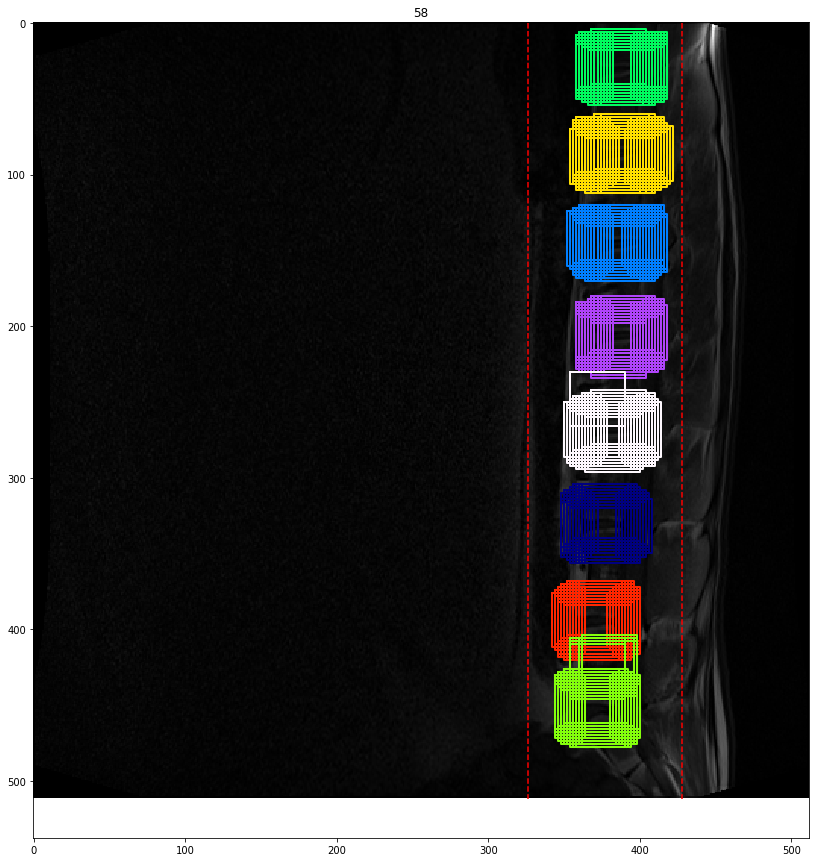

In [6]:
# chose the best n by using calinski_harabasz_score and silhouette_score
scores = np.zeros((5,2))
for k in range(6,11):
    cluster_model = GaussianMixture(n_components = k)
    #cluster_model = KMeans(n_clusters = n)
    indices_pred = cluster_model.fit_predict(pos_indices_point)
    scores[k-6,0] = metrics.calinski_harabasz_score(pos_indices_point, indices_pred)
    scores[k-6,1] = metrics.silhouette_score(pos_indices_point, indices_pred)

scores[:,0] = (scores[:,0] - scores[:,0].mean())/(scores[:,0].std())
scores[:,1] = (scores[:,1] - scores[:,1].mean())/(scores[:,1].std())
scores = np.sum(scores,axis=1)
k_chosen = scores.argmax() + 6

cluster_model = GaussianMixture(n_components = k_chosen)
indices_pred = cluster_model.fit_predict(pos_indices_point)
score = metrics.calinski_harabasz_score(pos_indices_point, indices_pred)
print('n of clustering is:', k_chosen,
      '\nCalinski-Harabasz socre: ', score)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, k_chosen)]

plt.figure(figsize = (15,15))
plt.imshow(im_T1,cmap='gray')
[plot_roi_from_indice(im_T1, input_size, pos_indices[i], colors[indices_pred[i]]) for i in range(len(pos_indices))] # indice第1/2个是高度/宽度
plt.plot((l,l),(0,im_T1.shape[0]),'--r')
plt.plot((r,r),(0,im_T1.shape[0]),'--r')
plt.title(n)
plt.show()

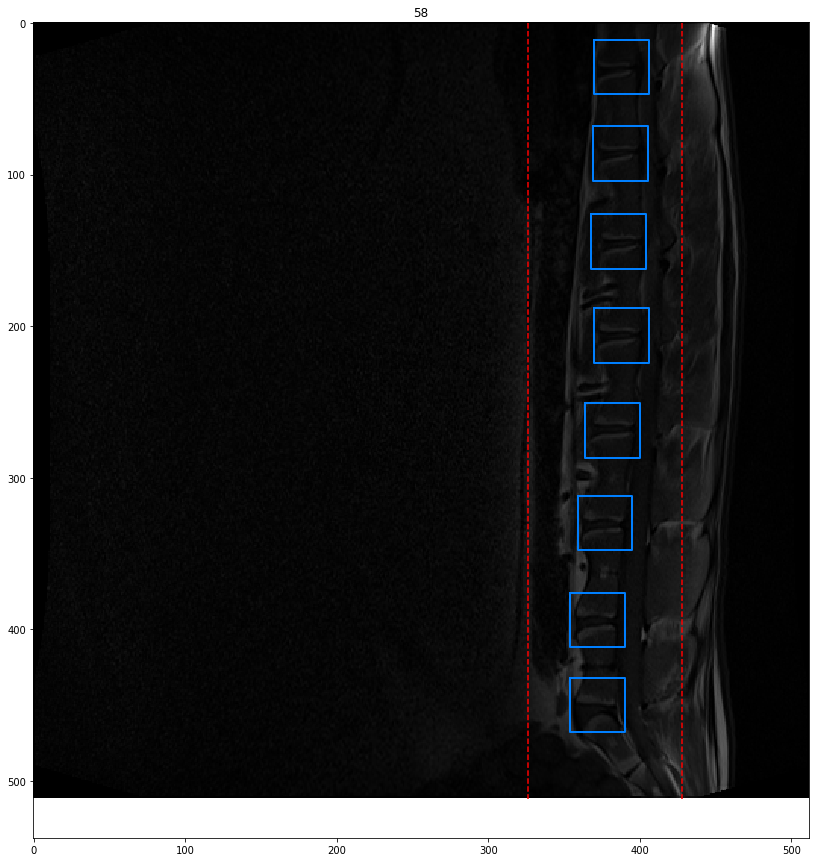

In [15]:
# 想要对这个结果做评价，现在有预测结果了，但是还没有gt,要找ground_truth
def ground_truth(im, pos, indices, tol = 5):
    dir_labels = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\positive ROI'
    dir_labels = os.path.join(dir_labels,'T'+str(pos[0])+' SAG')
    dir_labels = os.path.join(dir_labels,str(pos[1])+'_'+str(pos[2]))
    rois_dict = read_roi_zip(dir_labels + '.zip')
    axis_ens = np.array(rois_dict_to_axis(rois_dict))
    #axis_ens = reduce_size_from_indice(axis_ens, modify_label_size)
    
    gt_true = np.zeros(indices.shape[0],)  # 第一列是gt,第二列是preds
    gt = []
    for (x,y,_,_) in axis_ens:
        x += ceil((label_size[0]-modify_label_size[0])/2)
        y += floor((label_size[0]-modify_label_size[0])/2)
        gt.append([y,x])
    gt = np.array(gt)
    
    tol += modify_label_size[0] - input_size[0]
    for i,(test_y,test_x) in enumerate(indices):
        for (gt_y,gt_x) in gt:
            if (test_y-gt_y)< tol and (test_x-gt_x)< tol:
                gt_true[i] = 1
                continue
                
    return gt_true


center_indices = np.around(cluster_model.means_).astype(np.int64)
preds = np.ones(center_indices.shape[0],)       # vector
#gt = ground_truth(im_T1, pos_T1[n], center_indices)

# evaluation using sklearn
# 分类准确率, 是指所有分类正确的百分比
#print('accuracy_score: ',accuracy_score(gt, preds))
# 召回率 = 在所有正的样本里面预测正确的比例。通俗地说，就是所有准确的条目有多少被检索出来了
#print('recall_score: ',recall_score(gt, preds)) 
# 查准率, 指的是在所有预测正的里面正确的比例
#print('precision_score: ',precision_score(gt, preds))

# Confusion matrix such that Cij is equal to the number of observations known to be in group i and predicted to be in group j.
#print('confusion matrix:\n', confusion_matrix(preds, gt, labels=range(num_classes)))

plt.figure(figsize = (15,15))
plt.imshow(im_T1,cmap='gray')
#[plot_roi_from_indice(im_T1, input_size, center_indices[i], colors[2]) for i in range(len(center_indices)) if (preds[i]==1 and gt[i]==1)] 
#[plot_roi_from_indice(im_T1, input_size, center_indices[i], colors[1]) for i in range(len(center_indices)) if (preds[i]==1 and gt[i]==0)] 
[plot_roi_from_indice(im_T1, input_size, center_indices[i], colors[1]) for i in range(len(center_indices)) if preds[i]==1] 
plt.plot((l,l),(0,im_T1.shape[0]),'--r')
plt.plot((r,r),(0,im_T1.shape[0]),'--r')
plt.title(n)
plt.show()

In [ ]:
def extract_rois_from_image(im, input_size, indices):
    rois = []
    for x,y in indices:
        rois.append(im[x:x+input_size[1],y:y+input_size[0]])
    return rois

def from_normalization_to_origin(rois, conf):
    return (np.array(rois) * conf[1] + conf[0]).astype(np.int16)

# 去掉最下面那一个roi
ind = np.argmax(center_indices,0)[0]
center_indices = np.delete(center_indices, obj = ind, axis = 0)
if len(center_indices) >= 7:
    ind = np.argmin(center_indices,0)[0]
    center_indices = np.delete(center_indices, obj = ind, axis = 0)

rois = extract_rois_from_image(im_T1, input_size, center_indices)
#rois = from_normalization_to_origin(rois, confs_T1[n])

plt.figure(figsize = (20,5))
for i, roi in enumerate(rois): 
    plt.subplot(3,len(rois),i+1)
    plt.imshow(rois[i],cmap='gray')
    plt.axis('off')

rois_mask = [gmm(rois[i], input_size, 5) for i in range(len(rois))]
rois_mask = np.array(rois_mask)
for i, roi in enumerate(rois): 
    plt.subplot(3,len(rois),i+1+len(rois))
    plt.imshow(rois_mask[i],cmap='gray')
    plt.axis('off')

# pretraitement
for i, roi in enumerate(rois):
    roi = median(roi, disk(3))
    roi = gaussian(roi,sigma=1)
    roi_mask = gmm(roi, input_size, 5)
    plt.subplot(3,len(rois),i+1+2*len(rois))
    plt.imshow(roi_mask,cmap='gray')
    plt.axis('off')

plt.show()
#rois_mask = [gmm(rois[i], input_size, 3) for i in range(len(rois))]
#rois_mask = np.array(rois_mask)

In [ ]:
def find_central_region(roi_mask, input_size):
    # center region, 为了找最中间部分分类的标签
    roi_mask = roi_mask.astype(np.int)
    center = (round(input_size[0]/2),round(input_size[1]/2))
    rect_x = center[0] + np.linspace(-6,6,13).astype(np.int)
    rect_y = center[1] + np.linspace(-2,2,5).astype(np.int)
    rect = []
    for x in rect_x:
        for y in rect_y:
            rect.append([y,x])
    rect = np.array(rect)
    label = np.argmax(np.bincount(roi_mask[rect[:,0],rect[:,1]]))     # 统计在rect中出现最多的indice
    
    biggest_surf = 0
    best_rayons = (3,1)
    best_centers =(input_size[0]//2, input_size[1]//2)
    # 遍历圆心cx,cy和长短半径rx,ry,为了找最适合的椭圆
    for c_x in range(input_size[1]//2-2, input_size[1]//2+2+1):
        for c_y in range(input_size[0]//2-2, input_size[0]//2+2+1):
            centers = (c_x,c_y)
            for r_y in range(1,5):
                for r_x in range(r_y+3,r_y+10):
                    rayons = (r_x, r_y)
                    crit = ellipse_criterion(roi_mask, centers, rayons, label, input_size)
                    surf = np.pi * r_x * r_y  # 计算这个椭圆的面积，留下满足crit的面积最大的那个
                    if crit is True and surf > biggest_surf:
                        biggest_surf = surf
                        best_rayons = rayons
                        best_centers = centers

    return best_centers, best_rayons

def find_lateral_regions(roi_mask, input_size, inds_lateral):
    # left and right region, 为了找边上部分分类的标签
    roi_mask = roi_mask.astype(np.int)
    center = (round(input_size[0]/2),round(input_size[1]/2))
    rect_x = center[0] + np.linspace(-6,6,13).astype(np.int)
    rect_y = center[1] + np.linspace(-2,2,5).astype(np.int)
    rect = []
    for x in rect_x:
        for y in rect_y:
            rect.append([y,x])
    rect = np.array(rect)
    label = np.argmax(np.bincount(roi_mask[rect[:,0],rect[:,1]]))     # 统计在rect中出现最多的indice

def ellipse_criterion(roi_mask, centers, rayons, label, input_size):    
    crit = True
    for x in range(input_size[1]):
        for y in range(input_size[0]):
            if ((x-centers[0])/rayons[0])**2 + ((y-centers[1])/rayons[1])**2 < 1:
                if roi_mask[y,x] != label:
                    crit = False
    return crit
        
    
    
def find_three_regions(rois, input_size):
    rois_mask = []
    # center region
    center = (round(input_size[0]/2),round(input_size[1]/2))
    rect_x = center[0] + np.linspace(-6,6,13).astype(np.int)
    rect_y = center[1] + np.linspace(-2,2,5).astype(np.int)
    rect1 = []
    for x in rect_x:
        for y in rect_y:
            rect1.append([y,x])
    rect1 = np.array(rect1)
    
    # left region
    center_l = (round(input_size[0]/2-11),round(input_size[1]/2))
    rect_x = center_l[0] + np.linspace(-3,3,7).astype(np.int)
    rect_y = center_l[1] + np.linspace(-3,3,7).astype(np.int)
    rect2 = []
    for x in rect_x:
        for y in rect_y:
            rect2.append([y,x])
    rect2 = np.array(rect2)
    
    # right region
    center_r = (round(input_size[0]/2+11),round(input_size[1]/2))
    rect_x = center_r[0] + np.linspace(-3,3,7).astype(np.int)
    rect_y = center_r[1] + np.linspace(-3,3,7).astype(np.int)
    rect3 = []
    for x in rect_x:
        for y in rect_y:
            rect3.append([y,x])
    rect3 = np.array(rect3)
    center_r = (round(input_size[0]/2+12),round(input_size[1]/2))
    rect23 = np.concatenate((rect2,rect3),axis=0)
    
    plt.figure(figsize=(3*len(rois),3*3))
    for i in range(len(rois)):
        roi = rois[i].copy()
        roi = median(roi, disk(3))
        roi = gaussian(roi,sigma=3)
        #roi = laplace(roi, ksize=3)
        roi_mask = roi.copy()
        #label1 = np.argmax(np.bincount(roi_mask[rect1[:,0],rect1[:,1]]))     # 统计在rect1中出现最多的indice（0,1 or 2）
        #label23 = np.argmax(np.bincount(roi_mask[rect23[:,0],rect23[:,1]]))
        
        #roi_c = np.array(rect1[np.argwhere(roi_mask[rect1[:,0],rect1[:,1]] == label1)]).squeeze()
        #roi_l = np.array(rect2[np.argwhere(roi_mask[rect2[:,0],rect2[:,1]] == label23)]).squeeze()
        #roi_r = np.array(rect3[np.argwhere(roi_mask[rect3[:,0],rect3[:,1]] == label23)]).squeeze()
        #print(np.argwhere(roi_mask[rect1[:,0],rect1[:,1]]))
        
        ## plot line 1
        plt.subplot(3,len(rois),i+1)
        plt.imshow(rois[i], cmap="gray")
        
        # reduce up, down,left and right border
        tol = 2
        roi_l = roi[:, :input_size[1]//2].copy()
        roi_r = roi[:, input_size[1]//2:].copy()
        roi_up = roi[:input_size[1]//2, :].copy()
        roi_dn = roi[input_size[1]//2:, :].copy()
        
        fd, hog_im = hog(roi_up, orientations=8, pixels_per_cell=(2, input_size[1]),
                    cells_per_block=(1, 1), visualize=True)
        vals = hog_im[:, input_size[1]//2]
        inds = np.argsort(vals)
        inds = inds[-tol:]
        ind_up = inds.min()
        roi_mask[0:ind_up,:] = 0
        
        fd, hog_im = hog(roi_dn, orientations=8, pixels_per_cell=(2, input_size[1]),
                    cells_per_block=(1, 1), visualize=True)
        vals = hog_im[:, input_size[1]//2]
        inds = np.argsort(vals)
        inds = inds[-tol:]
        ind_dn = inds.max() + input_size[0]//2
        roi_mask[ind_dn:,:] = 0
        
        fd, hog_im = hog(roi_l, orientations=8, pixels_per_cell=(input_size[0], 2),
                    cells_per_block=(1, 1), visualize=True)
        vals = hog_im[input_size[0]//2, :]
        inds = np.argsort(vals)
        inds = inds[-tol:]
        ind_l = inds.min()
        roi_mask[:,0:ind_l] = 0
        
        fd, hog_im = hog(roi_r, orientations=8, pixels_per_cell=(input_size[0], 2),
                    cells_per_block=(1, 1), visualize=True)
        vals = hog_im[input_size[0]//2, :]
        inds = np.argsort(vals)
        inds = inds[-tol:]
        ind_r = inds.max() + input_size[1]//2
        roi_mask[:,ind_r:] = 0

        ## plot line 2
        size = (ind_dn-ind_up, ind_r-ind_l)
        roi_mask[ind_up:ind_dn, ind_l:ind_r] = gmm(roi[ind_up:ind_dn, ind_l:ind_r], size, 5)
        
        plt.subplot(3,len(rois),i+1+len(rois))
        plt.imshow(roi, cmap="gray")
        plt.plot((0, input_size[1]-1),(ind_up, ind_up), '-r')
        plt.plot((0, input_size[1]-1),(ind_dn, ind_dn), '-r')
        plt.plot((ind_l, ind_l), (0, input_size[0]-1), '-r')
        plt.plot((ind_r, ind_r), (0, input_size[0]-1), '-r')
        
        
        ## plot line 3
        centers0, best_rayons0 = find_central_region(roi_mask, input_size)
        #find_lateral_regions(roi_mask, input_size, (ind_l,ind_r))
        print('No.',i+1, '| Final centers:', centers0, '| Final rayons:', best_rayons0)
        t = np.linspace(0, 2*np.pi, 100)    
        x = centers0[0] + best_rayons0[0] * np.cos(t)
        y = centers0[1] + best_rayons0[1] * np.sin(t)
        init = np.array([x, y]).T                
        
        plt.subplot(3,len(rois),i+1+2*len(rois))
        plt.imshow(roi_mask, cmap="gray")
        plt.plot(init[:, 0], init[:, 1], '--r', lw=1)
        #plt.scatter(roi_r[:,1], roi_r[:,0])
        #plt.scatter(roi_c[:,1], roi_c[:,0])
        #plt.scatter(roi_l[:,1], roi_l[:,0])
        
        rois_mask.append(roi)
        
    plt.show()
    return rois_mask
rois_mask = find_three_regions(rois, input_size)